<a href="https://colab.research.google.com/github/thor4/neuralnets/blob/master/projects/1-CNN/step_3_process_logits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Process logits
---
Now we can load logits generated from each model and extract confidence and accuracy from them

## 1: Load logits
These logits were created using the `step2-generation_predictions-mobilenetv2_model.ipynb` and `step2-generation_predictions-vanilla_model.ipynb` Jupyter notebooks. Run the cell to download a zip file from OSF then extract the excel files `logits_mobilenetv2.xlsx` and `logits_vanilla.xlsx` into the current directory

In [1]:
# @title Download logits

import requests, os
from zipfile import ZipFile

print("Start downloading and unzipping `Model logits`...")
name = 'logits'
fname = f"{name}.zip"
url = f"https://osf.io/78qh5/download" #osf share link
r = requests.get(url, allow_redirects=True)
with open(fname, 'wb') as fh:
  fh.write(r.content) #download file

with ZipFile(fname, 'r') as zfile:
  zfile.extractall() #extract contents

if os.path.exists(fname):
  os.remove(fname) #delete zip file
else:
  print(f"The file {fname} does not exist")

print("Download completed.")

Start downloading and unzipping `Model logits`...
Download completed.


Import libraries first.

In [2]:
import pandas as pd
import numpy as np
from scipy.special import expit as sigmoid #get sigmoid function

Now we can load the logits into pandas dataframes

In [3]:
df_mnet = pd.read_excel("logits_mobilenetv2.xlsx") #mobilenetv2 logits
df_van = pd.read_excel("logits_vanilla.xlsx") #vanilla logits
df_vgg = pd.read_excel("logits_vgg16.xlsx") #vanilla logits
print(df_mnet.head())
print(df_van.head())
print(df_vgg.head())

     Logits  Labels
0  0.263464       0
1  0.380446       0
2 -0.105008       0
3  0.152609       0
4 -0.277837       0
     Logits  Labels
0  0.272361       0
1  0.403442       0
2 -0.132354       0
3 -0.137108       0
4  0.086970       0
     Logits  Labels
0 -0.477056       0
1  0.891860       0
2 -1.282907       0
3 -0.920217       0
4 -0.224539       0


## 2: Process mobileNetV2 model

First, we will get the confidence and accuracy for each dataset with the MobileNetv2 model.

Define the confidence threshold for high confidence.

In [ ]:
thres_min = -0.5
thres_max = 0.5

Next, let's define the function to get confidence and accuracy.

In [5]:
def get_conf_acc(df, thres_min, thres_max):
    df['Predictions'] = df['Logits'].apply(sigmoid) #sigmoid-transform the logits
    df['Predictions'] = np.where((df['Predictions'] < 0.5), 0, 1) #replace predictions with 0 or 1
    df['Accuracy'] = np.where((df['Labels'] == df['Predictions']), 1, 0)
    conditions = [
    (df['Logits'] < thres_min) | (df['Logits'] > thres_max), #high conf
    (df['Logits'] >= thres_min) | (df['Logits'] <= thres_max) #low conf
    ]
    values = ['high', 'low']
    df['Confidence'] = np.select(conditions, values)
    return df

Now we will assign confidence and accuracy to all 18,000 logits at once for the MobileNetv2 model.

In [ ]:
df = get_conf_acc(df_mnet,thres_min,thres_max)
print(df.iloc[5000:5010])

        Logits  Labels  Predictions  Accuracy Confidence
5000 -0.126332       0            0         1        low
5001 -1.941892       0            0         1       high
5002 -1.478281       0            0         1       high
5003 -1.361156       0            0         1       high
5004 -0.520181       0            0         1       high
5005  0.062038       0            1         0        low
5006 -0.320940       0            0         1        low
5007 -0.122390       0            0         1        low
5008 -1.939577       0            0         1       high
5009 -1.346852       0            0         1       high


Next, we will calculate the accuracy and confidence for each of the 18 datasets.

In [ ]:
span = range(0, 18000, 1000)
df_results = pd.DataFrame(columns=['Accuracy','Confidence']) #initialize dataframe
for n in span:
  set = df[n:n+1000] #extract dataset
  acc = set['Accuracy'].mean() #calculate avg accuracy
  conf = set['Confidence'].value_counts(normalize=True).loc['high'] #calculate avg high confidence
  df_results = pd.concat([df_results, pd.DataFrame({'Accuracy':[acc],
                                                    'Confidence':[conf]})], 
                         axis=0, ignore_index=True) #append logits & labels to dataframe

And add the tilt/contrast columns.

In [ ]:
df_results = df_results.assign(Tilt = [0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.4, 0.4, 0.4, 
                                 0.8, 0.8, 0.8, 1.6, 1.6, 1.6, 3.2, 3.2, 3.2],
                         Contrast = [0.3, 0.45, 1, 0.3, 0.45, 1, 0.3, 0.45, 1, 
                                     0.3, 0.45, 1, 0.3, 0.45, 1, 0.3, 0.45, 1])

Now, we have results for accuracy and confidence for each of the 18 datasets with different tilt/contrast combinations.

In [ ]:
df_results

,Accuracy,Confidence,Tilt,Contrast
0,0.543,0.040,0.1,0.30
1,0.522,0.192,0.1,0.45
2,0.512,0.718,0.1,1.00
3,0.558,0.038,0.2,0.30
4,0.570,0.208,0.2,0.45
5,0.628,0.737,0.2,1.00
6,0.560,0.046,0.4,0.30
7,0.564,0.171,0.4,0.45
8,0.708,0.762,0.4,1.00
9,0.552,0.049,0.8,0.30


We can group the results by tilt and contrast for a clearer visualization.

In [ ]:
df_results_groupbyta = df_results.reset_index().set_index(['Tilt','Contrast'])
del df_results_groupbyta['index']
df_results_groupbyta

Accuracy  Confidence
Tilt Contrast                      
0.1  0.30         0.543       0.040
     0.45         0.522       0.192
     1.00         0.512       0.718
0.2  0.30         0.558       0.038
     0.45         0.570       0.208
     1.00         0.628       0.737
0.4  0.30         0.560       0.046
     0.45         0.564       0.171
     1.00         0.708       0.762
0.8  0.30         0.552       0.049
     0.45         0.578       0.195
     1.00         0.879       0.839
1.6  0.30         0.582       0.045
     0.45         0.660       0.264
     1.00         0.987       0.968
3.2  0.30         0.648       0.069
     0.45         0.832       0.395
     1.00         1.000       1.000

Finally, we can save these results as an Excel spreadsheet.

In [ ]:
results_excel_filepath = os.path.join(os.getcwd(), 'results_mobilenetv2.xlsx') #prep path to save to

df_results_groupbyta.to_excel(results_excel_filepath, index=True) #save to disk

## 3: Process vanilla model

Next, we will apply the same process to get confidence and accuracy for each dataset using the vanilla model.

In [ ]:
thres_min = -5 #set confidence threshold
thres_max = 5
df = get_conf_acc(df_van,thres_min,thres_max)
print(df.iloc[5000:5010])

        Logits  Labels  Predictions  Accuracy Confidence
5000 -3.986970       0            0         1        low
5001 -6.465475       0            0         1       high
5002 -5.286637       0            0         1       high
5003 -4.856585       0            0         1        low
5004 -2.694278       0            0         1        low
5005 -5.261054       0            0         1       high
5006 -3.786383       0            0         1        low
5007 -4.152411       0            0         1        low
5008 -5.494016       0            0         1       high
5009 -2.461650       0            0         1        low


In [ ]:
span = range(0, 18000, 1000)
df_results = pd.DataFrame(columns=['Accuracy','Confidence']) #initialize dataframe
for n in span:
  set = df[n:n+1000] #extract dataset
  acc = set['Accuracy'].mean() #calculate avg accuracy
  conf = set['Confidence'].value_counts(normalize=True).loc['high'] #calculate avg high confidence
  df_results = pd.concat([df_results, pd.DataFrame({'Accuracy':[acc],
                                                    'Confidence':[conf]})], 
                         axis=0, ignore_index=True) #append logits & labels to dataframe
df_results = df_results.assign(Tilt = [0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.4, 0.4, 0.4, 
                                 0.8, 0.8, 0.8, 1.6, 1.6, 1.6, 3.2, 3.2, 3.2],
                         Contrast = [0.3, 0.45, 1, 0.3, 0.45, 1, 0.3, 0.45, 1, 
                                     0.3, 0.45, 1, 0.3, 0.45, 1, 0.3, 0.45, 1])
df_results

,Accuracy,Confidence,Tilt,Contrast
0,0.676,0.023,0.1,0.30
1,0.730,0.023,0.1,0.45
2,0.941,0.026,0.1,1.00
3,0.779,0.034,0.2,0.30
4,0.899,0.085,0.2,0.45
5,1.000,0.338,0.2,1.00
6,0.932,0.134,0.4,0.30
7,0.992,0.391,0.4,0.45
8,1.000,0.998,0.4,1.00
9,1.000,0.685,0.8,0.30


In [ ]:
df_results_groupbyta = df_results.reset_index().set_index(['Tilt','Contrast'])
del df_results_groupbyta['index']
df_results_groupbyta

Accuracy  Confidence
Tilt Contrast                      
0.1  0.30         0.676       0.023
     0.45         0.730       0.023
     1.00         0.941       0.026
0.2  0.30         0.779       0.034
     0.45         0.899       0.085
     1.00         1.000       0.338
0.4  0.30         0.932       0.134
     0.45         0.992       0.391
     1.00         1.000       0.998
0.8  0.30         1.000       0.685
     0.45         1.000       0.975
     1.00         1.000       1.000
1.6  0.30         1.000       0.998
     0.45         1.000       1.000
     1.00         1.000       1.000
3.2  0.30         1.000       1.000
     0.45         1.000       1.000
     1.00         1.000       1.000

In [ ]:
results_excel_filepath = os.path.join(os.getcwd(), 'results_vanilla.xlsx') #prep path to save to
df_results_groupbyta.to_excel(results_excel_filepath, index=True) #save to disk

## 4: Process vgg16 model

Next, we will apply the same process to get confidence and accuracy for each dataset using the vgg16 model.

In [6]:
thres_min = -0.5 #set confidence threshold
thres_max = 0.5
df = get_conf_acc(df_vgg,thres_min,thres_max)
print(df.iloc[5000:5010])

        Logits  Labels  Predictions  Accuracy Confidence
5000 -0.220328       0            0         1        low
5001  2.411740       0            1         0       high
5002 -0.606072       0            0         1       high
5003 -2.075734       0            0         1       high
5004 -3.790444       0            0         1       high
5005  0.071362       0            1         0        low
5006 -1.198998       0            0         1       high
5007  1.438296       0            1         0       high
5008 -1.888384       0            0         1       high
5009 -1.893157       0            0         1       high


In [12]:
span = range(0, 18000, 1000)
df_results = pd.DataFrame(columns=['Accuracy','Confidence']) #initialize dataframe
for n in span:
  set = df[n:n+1000] #extract dataset
  acc = set['Accuracy'].mean() #calculate avg accuracy
  #conf = set['Confidence'].value_counts(normalize=True).loc['high'] #calculate avg high confidence
  conf = set['Logits'].abs().mean() #calculate avg raw confidence with no threshold
  df_results = pd.concat([df_results, pd.DataFrame({'Accuracy':[acc],
                                                    'Confidence':[conf]})], 
                         axis=0, ignore_index=True) #append logits & labels to dataframe
df_results = df_results.assign(Tilt = [0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.4, 0.4, 0.4, 
                                 0.8, 0.8, 0.8, 1.6, 1.6, 1.6, 3.2, 3.2, 3.2],
                         Contrast = [0.3, 0.45, 1, 0.3, 0.45, 1, 0.3, 0.45, 1, 
                                     0.3, 0.45, 1, 0.3, 0.45, 1, 0.3, 0.45, 1])
df_results_groupbyta = df_results.reset_index().set_index(['Tilt','Contrast'])
del df_results_groupbyta['index']
df_results_groupbyta

Accuracy  Confidence
Tilt Contrast                      
0.1  0.30         0.616    0.495122
     0.45         0.574    0.544343
     1.00         0.536    1.197594
0.2  0.30         0.598    0.483895
     0.45         0.617    0.584853
     1.00         0.607    1.271447
0.4  0.30         0.602    0.491867
     0.45         0.655    0.590938
     1.00         0.694    1.406271
0.8  0.30         0.592    0.491718
     0.45         0.645    0.610259
     1.00         0.932    2.141970
1.6  0.30         0.634    0.529203
     0.45         0.752    0.728632
     1.00         0.992    3.317382
3.2  0.30         0.720    0.574002
     0.45         0.911    1.055095
     1.00         1.000    6.168284

In [13]:
results_excel_filepath = os.path.join(os.getcwd(), 'results_vgg16.xlsx') #prep path to save to
df_results_groupbyta.to_excel(results_excel_filepath, index=True) #save to disk

## 5: Work on visualizations

In [14]:
import seaborn as sns

In [15]:
df_results

,Accuracy,Confidence,Tilt,Contrast
0,0.616,0.495122,0.1,0.30
1,0.574,0.544343,0.1,0.45
2,0.536,1.197594,0.1,1.00
3,0.598,0.483895,0.2,0.30
4,0.617,0.584853,0.2,0.45
5,0.607,1.271447,0.2,1.00
6,0.602,0.491867,0.4,0.30
7,0.655,0.590938,0.4,0.45
8,0.694,1.406271,0.4,1.00
9,0.592,0.491718,0.8,0.30


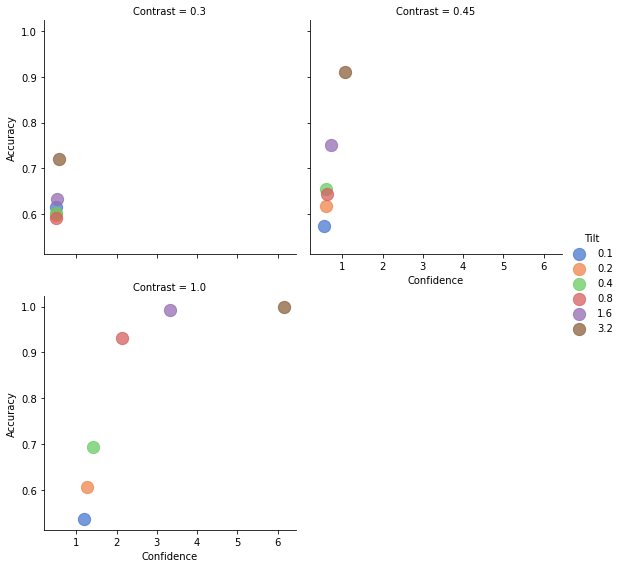

In [31]:
sns.lmplot(x="Confidence", y="Accuracy", col="Contrast", hue="Tilt", data=df_results,
           col_wrap=2, palette="muted", height=4,
           scatter_kws={"s": 150, "alpha": 0.75})

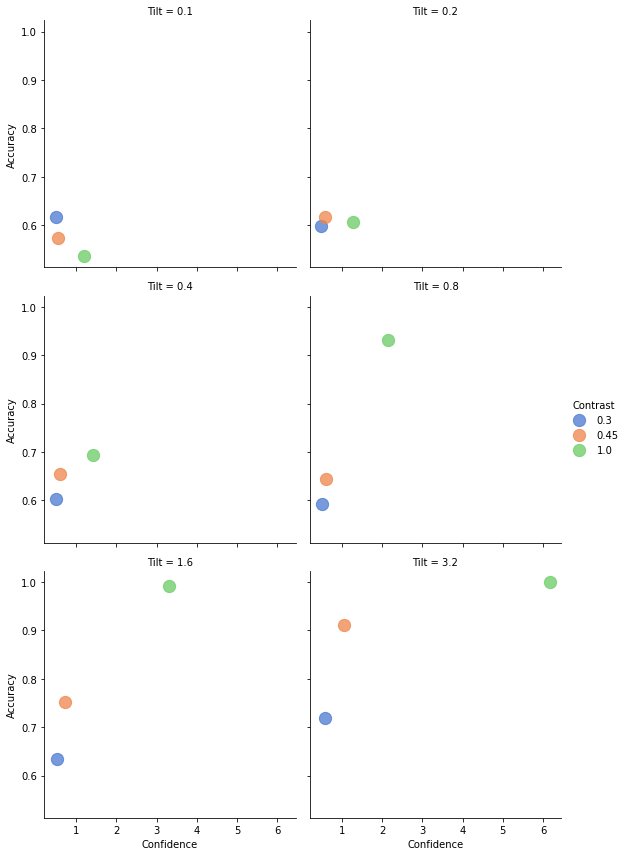

In [30]:
sns.lmplot(x="Confidence", y="Accuracy", col="Tilt", hue="Contrast", data=df_results,
           col_wrap=2, palette="muted", height=4,
           scatter_kws={"s": 150, "alpha": 0.75})

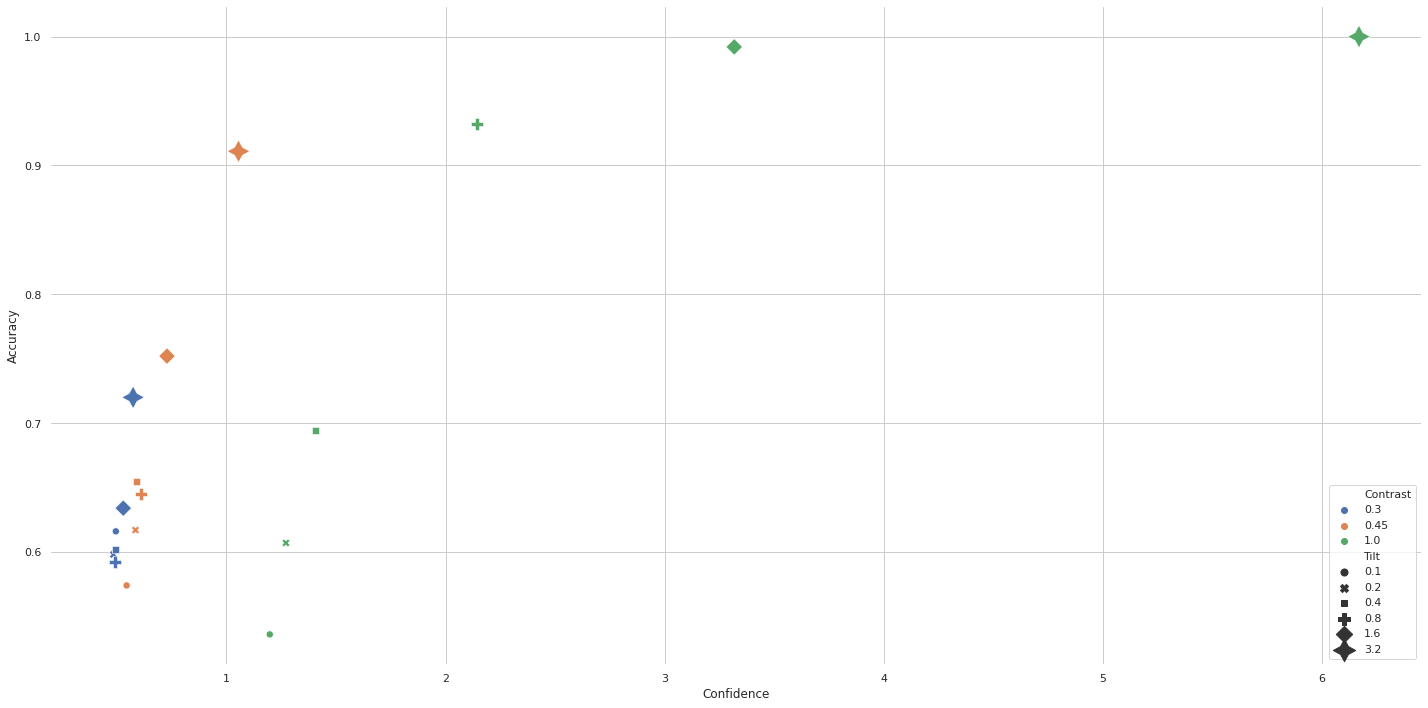

In [67]:
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(20, 10))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="Confidence", y="Accuracy",
                hue="Contrast", size="Tilt",
                palette="deep",
                sizes=(50,500), style="Tilt",
                data=df_results, ax=ax)
plt.legend(loc='lower right')
fig=plt.gcf()
plt.tight_layout()
plt.savefig('conf_acc_vgg16.png', transparent=True, dpi=300)

This one seems to be best. We exported it as png for future reference.

 ## Followup
 - want to see how robust this is, take a range of confidence thresholds

 - probably need to retrain vanilla model to decimate accuracy until it matches behavioral experiment more closesly (~75%)

- what about comparing the logits each model generates for each stimulus? some stimuli within datasets appear to drive confidence more than others. models do better with some stimulus images than others. maybe they specialize in a type of image